# End to End Sequence Labelling using BiLSTM CNN CRF for NER
This project aims to perform **End to End Sequence Labelling**  on English data from CoNLL using BiLSTM CNN CRF for Named Entity Recognition.

This project aims to implement the pytorch [model](https://https://github.com/jayavardhanr/End-to-end-Sequence-Labeling-via-Bi-directional-LSTM-CNNs-CRF-Tutorial/blob/master/Named_Entity_Recognition-LSTM-CNN-CRF-Tutorial.ipynb) of BiLSTM CNN CRF in Tensorflow Keras. We will use Convolution Neural Network Encoding for Character Level Representation of words, Bidirectional LSTM for Word Level Encoding and Conditional Random Fields (CRF Layer) for output decodings.

Following are the libraries that we will import.

In [0]:
# Import Libraries
!pip install tensorflow-gpu
!pip install git+https://www.github.com/keras-team/keras-contrib.git
!pip install sklearn-crfsuite
import tensorflow as tf
import keras
from keras.layers import TimeDistributed, Conv1D, Dense, Embedding, Input, Dropout, LSTM, Bidirectional, MaxPooling1D,Flatten, concatenate
from keras_contrib.losses import crf_loss
from keras_contrib.metrics import crf_viterbi_accuracy
from keras_contrib.layers.crf import CRF
from keras.utils import plot_model
from keras.initializers import RandomUniform
from keras.optimizers import SGD, Nadam
import numpy as np
import os
import sys
import codecs
import re
import pickle
from sklearn_crfsuite.metrics import flat_classification_report
import matplotlib.pyplot as plt

## Download Data

In [0]:
# Downloading Data
!mkdir data
!wget https://raw.githubusercontent.com/mxhofer/Named-Entity-Recognition-BidirectionalLSTM-CNN-CoNLL/master/data/train.txt -P /content/data
!wget https://raw.githubusercontent.com/mxhofer/Named-Entity-Recognition-BidirectionalLSTM-CNN-CoNLL/master/data/dev.txt -P /content/data
!wget https://raw.githubusercontent.com/mxhofer/Named-Entity-Recognition-BidirectionalLSTM-CNN-CoNLL/master/data/test.txt -P /content/data

## Data Preprocessing
Data prepocessing includes loading the data, updating the tagging scheme, create mapping for words, characters and tags and finally preparing the data that is passed into the model.

### Custom Data Loading
This step includes loading the train and validation data into list of sentences. 

Following code loads the training and validation data.

In [0]:
def load_sentences(filename):
    f = open(filename)
    sentences = []
    sentence = []
    for line in f:
        if len(line) == 0 or line.startswith('-DOCSTART') or line[0] == "\n":
            if len(sentence) > 0:
                sentences.append(sentence)
                sentence = []
            continue
        splits = line.split(' ')
        sentence.append([splits[0], splits[-1]])

    if len(sentence) > 0:
        sentences.append(sentence)
        sentence = []
    return sentences

In [5]:
train_sentences = load_sentences("/content/data/train.txt")
dev_sentences = load_sentences("/content/data/dev.txt")
test_sentences = load_sentences("/content/data/test.txt")
len(train_sentences), len(dev_sentences), len(test_sentences)

(14041, 3250, 3453)

### Add Character Information

In [0]:
def add_char_info(sentences):
    for i, sentence in enumerate(sentences):
        for j, data in enumerate(sentence):
            chars = [c for c in data[0]]
            sentences[i][j] = [data[0], chars, data[1]]
    return sentences

In [7]:
train_sentences = add_char_info(train_sentences)
dev_sentences = add_char_info(dev_sentences)
test_sentences = add_char_info(test_sentences)
train_sentences[0]

[['EU', ['E', 'U'], 'B-ORG\n'],
 ['rejects', ['r', 'e', 'j', 'e', 'c', 't', 's'], 'O\n'],
 ['German', ['G', 'e', 'r', 'm', 'a', 'n'], 'B-MISC\n'],
 ['call', ['c', 'a', 'l', 'l'], 'O\n'],
 ['to', ['t', 'o'], 'O\n'],
 ['boycott', ['b', 'o', 'y', 'c', 'o', 't', 't'], 'O\n'],
 ['British', ['B', 'r', 'i', 't', 'i', 's', 'h'], 'B-MISC\n'],
 ['lamb', ['l', 'a', 'm', 'b'], 'O\n'],
 ['.', ['.'], 'O\n']]

### Tag Mappings

In [0]:
labels_set = set()
words = {}

# unique words and labels in data  
for dataset in [train_sentences, dev_sentences, test_sentences]:
  for sentence in dataset:
    for token, char, label in sentence:
      # token ... token, char ... list of chars, label ... BIO labels   
      labels_set.add(label)
      words[token.lower()] = True

In [20]:
# mapping for labels
indexes = {"PADDING":0}
for label in labels_set:
  indexes[label] = len(indexes)

  
tag_to_id = {}
for word,index in indexes.items():
  if index != 0:
    word = word[:len(word)-1]
  
  tag_to_id[word] = index
  
tag_to_id

{'B-LOC': 2,
 'B-MISC': 4,
 'B-ORG': 6,
 'B-PER': 3,
 'I-LOC': 5,
 'I-MISC': 7,
 'I-ORG': 8,
 'I-PER': 9,
 'O': 1,
 'PADDING': 0}

In [12]:
id_to_tag = {v: k for k, v in tag_to_id.items()}
len(id_to_tag)

10

### Word and Character Embeddings

In [0]:
# Download Glove Word Embeddings
!wget http://nlp.stanford.edu/data/glove.6B.zip && unzip glove.6B.zip -d /content/

In [14]:
word_to_id = {}
word_embeddings = []

EMBEDDINGS_FILE = open("/content/glove.6B.50d.txt", encoding="utf-8")


# loop through each word in embeddings
for line in EMBEDDINGS_FILE:
    split = line.strip().split(" ")
    word = split[0]  # embedding word entry

    if len(word_to_id) == 0:  # add padding+unknown
        word_to_id["PADDING_TOKEN"] = len(word_to_id)
        vector = np.zeros(len(split) - 1)  # zero vector for 'PADDING' word
        word_embeddings.append(vector)

        word_to_id["UNKNOWN_TOKEN"] = len(word_to_id)
        vector = np.random.uniform(-0.25, 0.25, len(split) - 1)
        word_embeddings.append(vector)

    if split[0].lower() in words:
        vector = np.array([float(num) for num in split[1:]])
        word_embeddings.append(vector)  # word embedding vector
        word_to_id[split[0]] = len(word_to_id)  # corresponding word dict

word_embeddings = np.array(word_embeddings)
word_embeddings.shape, len(word_to_id)

((22949, 50), 22949)

In [15]:
id_to_word = {v: k for k, v in word_to_id.items()}
len(id_to_word)

22949

In [16]:
# dictionary of all possible characters
char_to_id = {"PADDING": 0, "UNKNOWN": 1}
for c in " 0123456789abcdefghijklmnopqrstuvwxyzABCDEFGHIJKLMNOPQRSTUVWXYZ.,-_()[]{}!?:;#'\"/\\%$`&=*+@^~|<>":
    char_to_id[c] = len(char_to_id)

len(char_to_id)

97

### Prepare Dataset

In [0]:
def create_dataset(sentences, word_to_id, tag_to_id, char_to_id):
    unk_index = word_to_id['UNKNOWN_TOKEN']
    pad_index = word_to_id['PADDING_TOKEN']

    dataset = []

    word_count = 0
    unk_word_count = 0

    for sentence in sentences:
        word_indices = []
        char_indices = []
        tag_indices = []

        for word, char, tag in sentence:
            word_count += 1
            if word in word_to_id:
                word_index = word_to_id[word]
            elif word.lower() in word_to_id:
                word_index = word_to_id[word.lower()]
            else:
                word_index = unk_index
                unk_word_count += 1
            char_index = []
            for x in char:
                char_index.append(char_to_id[x])
            # Get the label and map to int
            word_indices.append(word_index)
            char_indices.append(char_index)
            tag_indices.append(tag_to_id[tag])

        dataset.append([word_indices, char_indices, tag_indices])

    return dataset

In [0]:
def padding(sentences):
  maxlen = 52
  for sentence in sentences:
      char = sentence[1]
      for x in char:
          maxlen = max(maxlen, len(x))
  for i, sentence in enumerate(sentences):
      sentences[i][1] = keras.preprocessing.sequence.pad_sequences(sentences[i][1], 52, padding='post')
  return sentences

In [0]:
train_set = padding(create_dataset(train_sentences, word_to_id, indexes, char_to_id))
dev_set = padding(create_dataset(dev_sentences, word_to_id, indexes, char_to_id))
test_set = padding(create_dataset(test_sentences, word_to_id, indexes, char_to_id))


In [0]:
def unpack(dataset):
  words=[]
  chars=[]
  tags = []
  for word, char, tag in dataset:
    words.append(word)
    chars.append(char)
    tags.append(tag)
  
  words = keras.preprocessing.sequence.pad_sequences(words, 52, padding='post')
  chars = keras.preprocessing.sequence.pad_sequences(chars, 52, padding='post')
  tags = keras.preprocessing.sequence.pad_sequences(tags, 52, padding='post')
  tags = keras.utils.to_categorical(tags, num_classes=10)
  
  return words, chars, tags

In [0]:
train_words, train_chars, train_tags = unpack(train_set)
valid_words, valid_chars, valid_tags = unpack(dev_set)
test_words, test_chars, test_tags = unpack(test_set)

In [28]:
train_words.shape, train_chars.shape, train_tags.shape

((14041, 52), (14041, 52, 52), (14041, 52, 10))

## Define Model
The model that is implemented in this project uses the following architectures:
- Convolution Neural Network for Character Level Representation of words
- Bidirectional LSTM for Word Level Encoding
- Conditional Random Fields (CRF Layer) for output decodings.

In [30]:
# Define Model Layers
char_input = Input(shape=(None, 52,), name="char_input")
char_embed = TimeDistributed(Embedding(len(char_to_id), 30, embeddings_initializer=RandomUniform(minval=-0.5, maxval=0.5)), name="char_embed")(char_input)
char_dropout = Dropout(0.5)(char_embed)
char_cnn = TimeDistributed(Conv1D(kernel_size=3, filters=30, padding='same', activation='tanh', strides=1), name="conv1d")(char_dropout)
maxpool_out = TimeDistributed(MaxPooling1D(52), name="maxpool")(char_cnn)
char_flat = TimeDistributed(Flatten(), name="flatten")(maxpool_out)
char = Dropout(0.5)(char_flat)
words_input = Input(shape=(None,), dtype='int32', name='words_input')
words = Embedding(input_dim=word_embeddings.shape[0], output_dim=word_embeddings.shape[1], weights=[word_embeddings],trainable=False)(words_input)
concat = concatenate([words, char])
lstm = Bidirectional(LSTM(200, return_sequences=True, dropout=0.5,recurrent_dropout=0.25), name="bilstm")(concat)
out = TimeDistributed(Dense(len(tag_to_id), activation='softmax'),name="softmax_layer")(lstm)
crf_layer = CRF(10)
output = crf_layer(out)

# Define Model Inputs and Output
model = keras.models.Model([char_input,words_input],output)
# Compile Model
model.compile(optimizer='adam', loss=crf_loss, metrics=[crf_viterbi_accuracy])
# Model Summary
model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
char_input (InputLayer)         (None, None, 52)     0                                            
__________________________________________________________________________________________________
char_embed (TimeDistributed)    (None, None, 52, 30) 2910        char_input[0][0]                 
__________________________________________________________________________________________________
dropout_3 (Dropout)             (None, None, 52, 30) 0           char_embed[0][0]                 
__________________________________________________________________________________________________
conv1d (TimeDistributed)        (None, None, 52, 30) 2730        dropout_3[0][0]                  
__________________________________________________________________________________________________
maxpool (T

In [0]:
plot_model(model, to_file='/content/data/model.png')

## Training

In [32]:
history = model.fit([train_chars,train_words], train_tags,validation_data=[[valid_chars, valid_words], valid_tags],batch_size=64,epochs=20,verbose=1)

Train on 14041 samples, validate on 3250 samples
Epoch 1/20
14041/14041 [==============================] - 80s 6ms/step - loss: 1.3638 - crf_viterbi_accuracy: 0.7223 - val_loss: 0.9679 - val_crf_viterbi_accuracy: 0.7093
Epoch 2/20
14041/14041 [==============================] - 74s 5ms/step - loss: 0.6881 - crf_viterbi_accuracy: 0.7325 - val_loss: 0.5280 - val_crf_viterbi_accuracy: 0.7093
Epoch 3/20
14041/14041 [==============================] - 73s 5ms/step - loss: 0.4114 - crf_viterbi_accuracy: 0.9346 - val_loss: 0.3636 - val_crf_viterbi_accuracy: 0.9496
Epoch 4/20
14041/14041 [==============================] - 73s 5ms/step - loss: 0.3103 - crf_viterbi_accuracy: 0.9534 - val_loss: 0.3026 - val_crf_viterbi_accuracy: 0.9497
Epoch 5/20
14041/14041 [==============================] - 73s 5ms/step - loss: 0.2703 - crf_viterbi_accuracy: 0.9534 - val_loss: 0.2751 - val_crf_viterbi_accuracy: 0.9497
Epoch 6/20
14041/14041 [==============================] - 73s 5ms/step - loss: 0.2498 - crf_vite

## Training and Testing Accuracy

In [33]:
_, train_acc = model.evaluate([train_chars, train_words],train_tags)
_, val_acc = model.evaluate([valid_chars, valid_words], valid_tags)
_, test_acc = model.evaluate([test_chars, test_words],test_tags)

print('Training Accuray: ', train_acc * 100)
print('Validation Accuray: ', val_acc * 100)
print('Testing Accuray: ', test_acc * 100)

3453/3453 [==============================] - 10s 3ms/step
Training Accuray:  98.1763572632082
Validation Accuray:  98.02307686438927
Testing Accuray:  98.16213322314117


## Evaluation Metrics Report
Now we will use Precision, Recall and F1 score to evaluate the performance of our model on each tag.

In [34]:
# Evaluate
pred_cat = model.predict([test_chars,test_words])
predicted = [[[np.argmax(i)] for i in w] for w in pred_cat]
predicted = np.array(predicted)
actual = [[[np.argmax(i)] for i in w] for w in test_tags]
actual = np.array(actual)
# Convert the index to tag
predicted_tag = [[id_to_tag[i[0]] for i in row] for row in predicted]
actual_tag = [[id_to_tag[i[0]] for i in row] for row in actual]

# Metrics Report
report = flat_classification_report(y_pred=predicted_tag, y_true=actual_tag)
print(report)

              precision    recall  f1-score   support

       B-LOC       0.49      0.66      0.56      1653
      B-MISC       0.53      0.18      0.27       701
       B-ORG       0.56      0.56      0.56      1657
       B-PER       0.91      0.66      0.76      1582
       I-LOC       0.00      0.00      0.00       256
      I-MISC       0.42      0.33      0.37       216
       I-ORG       0.59      0.87      0.70       835
       I-PER       0.95      0.96      0.96      1122
           O       0.99      0.99      0.99     38169
     PADDING       1.00      1.00      1.00    133365

    accuracy                           0.98    179556
   macro avg       0.64      0.62      0.62    179556
weighted avg       0.98      0.98      0.98    179556



## Accuracy Curve

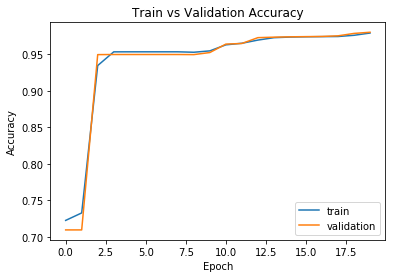

In [35]:
# Plotting Training vs Validation Accuracy
plt.plot(history.history['crf_viterbi_accuracy'])  
plt.plot(history.history['val_crf_viterbi_accuracy'])  
plt.title('Train vs Validation Accuracy')  
plt.ylabel('Accuracy')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation']) 
plt.show()

## Loss Curve

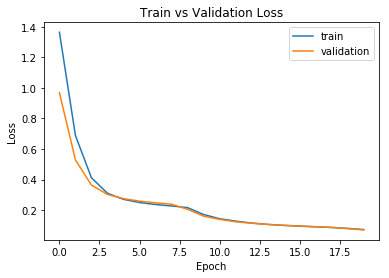

In [36]:
# Plotting Training vs Validation Accuracy
plt.plot(history.history['loss'])  
plt.plot(history.history['val_loss'])  
plt.title('Train vs Validation Loss')  
plt.ylabel('Loss')  
plt.xlabel('Epoch')  
plt.legend(['train', 'validation']) 
plt.show()

## Testing

In [39]:
good_example = []
bad_example = []

for i in range(5):
  for j in range(5):
    if test_words[i][j] != 0:
      word = id_to_word[test_words[i][j]]
      a_tag = actual_tag[i][j]
      p_tag = predicted_tag[i][j]
      if a_tag == p_tag:
        good_example.append([word, p_tag, a_tag])
      else:
        bad_example.append([word, p_tag, a_tag])

col1_width = max([len(x[0]) for x in good_example])
col2_width = max([len(x[1]) for x in good_example])
col3_width = max([len(x[2]) for x in good_example])

print("-------- Good Examples --------")
print ("|{0:<{col1}}  |{1:<{col2}}  |{2:<{col3}}  |".format("Word","Actual","Predicted",col1=col1_width,col2=col2_width,col3=col3_width))

for word, p_tag, a_tag in good_example:
  print ("|{0:<{col1}}  |{1:<{col2}}   |{2:<{col3}}      |".format(word,a_tag,p_tag,col1=col1_width,col2=col2_width,col3=col3_width))

col1_width = max([len(x[0]) for x in bad_example])
col2_width = max([len(x[1]) for x in bad_example])
col3_width = max([len(x[2]) for x in bad_example])  

print("\n\n-------- Bad Examples --------")
print ("|{0:<{col1}}  |{1:<{col2}}  |{2:<{col3}}  |".format("Word","Actual","Predicted",col1=col1_width,col2=col2_width,col3=col3_width))

for word, p_tag, a_tag in bad_example:
   print ("|{0:<{col1}}  |{1:<{col2}}   |{2:<{col3}}      |".format(word,a_tag,p_tag,col1=col1_width,col2=col2_width,col3=col3_width))

-------- Good Examples --------
|Word     |Actual  |Predicted  |
|soccer   |O       |O          |
|-        |O       |O          |
|japan    |B-LOC   |B-LOC      |
|get      |O       |O          |
|lucky    |O       |O          |
|nadim    |B-PER   |B-PER      |
|ladki    |I-PER   |I-PER      |
|al-ain   |B-LOC   |B-LOC      |
|,        |O       |O          |
|began    |O       |O          |
|the      |O       |O          |
|defence  |O       |O          |
|of       |O       |O          |
|but      |O       |O          |
|china    |B-LOC   |B-LOC      |
|saw      |O       |O          |
|their    |O       |O          |
|luck     |O       |O          |


-------- Bad Examples --------
|Word      |Actual  |Predicted  |
|united    |B-LOC   |B-ORG      |
|arab      |I-LOC   |I-ORG      |
|emirates  |I-LOC   |I-ORG      |
|japan     |B-LOC   |B-ORG      |
